In [ ]:
# load the library for path
from pathlib import Path
import pandas as pd
import openpyxl as xl
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
from numpy import *

In [ ]:
# import data set
data_dir = Path('../datathon')

# read xlsx data set
df = pd.read_csv(data_dir/'VacancyRate.csv', index_col = [0], parse_dates=[0])

# remove all the empty column
df = df.dropna(axis=1, how='all')
df.dropna(inplace=True)
df.index.format = '%Y-%m-%d'

plt.figure(figsize=(10, 6))
plt.plot(df)
plt.legend(loc = 'best')
plt.title('Vacancy Rate')
plt.show()

# 3. Test for Data Set
## 3.1 Stationary Test

In [ ]:
for i in range(df.shape[1]):
    column_name = df.columns[i]
    column_data = df.iloc[:, i]  # Access column data using iloc

    # Perform the ADF test
    adft = adfuller(column_data, autolag='AIC')
    
    if df.iloc[:, i].isna().any():
        df = df.dropna()

    # Create a DataFrame to display the ADF test results
    output_df = pd.DataFrame({
        "Values": [adft[0], adft[1], adft[2], adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']],
        "Metric": ["Test Statistics", "p-value", "No. of lags used", "Number of observations used",
                   "critical value (1%)", "critical value (5%)", "critical value (10%)"]
    })

    # Print the column name and ADF test results
    print(f"Results for {column_name}:")
    print(output_df, "\n")


## 3.2 Autocorrelation

In [ ]:
for i in range(df.shape[1]):
    column_name = df.columns[i]
    print(f"Results for {column_name}:")

    autocorrelation_lag1 = df.iloc[:, i].autocorr(lag=1)
    print("One Month Lag: ", autocorrelation_lag1)

    autocorrelation_lag3 = df.iloc[:, i].autocorr(lag=3)
    print("Three Month Lag: ", autocorrelation_lag3)

    autocorrelation_lag6 = df.iloc[:, i].autocorr(lag=6)
    print("Six Month Lag: ", autocorrelation_lag6)

    autocorrelation_lag9 = df.iloc[:, i].autocorr(lag=9)
    print("Nine Month Lag: ", autocorrelation_lag9)
    
    print("\n")

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

for i in range(df.shape[1]):
    column_name = df.columns[i]
    fig, ax = plt.subplots(2, figsize=(12,6))
    ax[0] = plot_acf(df.iloc[:, i], ax=ax[0], lags=6, title=f"Autocorrelation for {column_name}")
    ax[1] = plot_pacf(df.iloc[:, i], ax=ax[1], lags=6, title=f"Partial Autocorrelation for {column_name}")

## 3.3 Decomposition

# 4. Data Transformation

In [ ]:
df_diff = df.diff().dropna()

for i in range(df.shape[1]):
    column_name = df.columns[i]
    print(f"Results for {column_name}:")
    print("After differencing:")

    # perform the stationarity test
    adft = adfuller(df_diff.iloc[:, i], autolag='AIC')
    output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                                        "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
    print(output_df)
    print("\n")

    # autocorrelation
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

    fig, ax = plt.subplots(2, figsize=(12,6))
    ax[0] = plot_acf(df_diff.iloc[:,i], ax=ax[0], lags=6, title= f"Autocorrelation for {column_name}")
    ax[1] = plot_pacf(df_diff.iloc[:,i], ax=ax[1], lags=6, title= f"Partial Autocorrelation for {column_name}")
    

In [ ]:
# convert df_diff to data frame
df_diff = pd.DataFrame(df_diff)
df_diff.columns

In [ ]:
# second order differencing
df_diff_diff = df_diff['Pulau Pinang'].diff().dropna()
df_diff_diff = df_diff['W.P Kuala Lumpur'].diff().dropna()
df_diff_diff = df_diff['Pulau Pinang'].diff().dropna()

# 5. Fitting the Model

# Split the Data Set 

In [ ]:
train = df.iloc[:round(len(df)*0.8)]
test = df.iloc[round(len(df)*0.8):]
train.shape, test.shape

## ETS

In [ ]:
def find_ETS(train,test,column_number):
    Trend_choice = ['add','mul']
    Seasonal_choice = ['add','mul']

    MSE = pd.DataFrame({'Trend': [], 'Seasonal': [], 'MSE': [], 'RMSE': [], 'MAE': []})

    for value in Trend_choice:
        for value2 in Seasonal_choice:
            model = ExponentialSmoothing(train.iloc[:, column_number], trend=value, seasonal=value2, seasonal_periods=6)  
            model_fit = model.fit()
            forecasts = model_fit.forecast(steps=3)
            # Check the error measure for each model and update the MSE_johor DataFrame
            new_row = pd.DataFrame({'Trend': value, 
                                    'Seasonal': value2, 
                                    'MSE': mean_squared_error(test.iloc[:, column_number], forecasts),
                                    'RMSE': np.sqrt(mean_squared_error(test.iloc[:, column_number], forecasts)),
                                    'MAE': mean_absolute_error(test.iloc[:, column_number], forecasts)}, index=[0]) 
            MSE = pd.concat([MSE, new_row], ignore_index=True)
    return MSE


In [ ]:
ETS_johor = find_ETS(train,test,0)
ETS_kedah = find_ETS(train,test,1)
ETS_kelantan = find_ETS(train,test,2)
ETS_melaka = find_ETS(train,test,3)
ETS_n9 = find_ETS(train,test,4)
ETS_pahang = find_ETS(train,test,5)
ETS_penang = find_ETS(train,test,6)
ETS_perak = find_ETS(train,test,7)
ETS_perlis = find_ETS(train,test,8)
ETS_selangor = find_ETS(train,test,9)
ETS_terengganu = find_ETS(train,test,10)
ETS_sabah = find_ETS(train,test,11)
ETS_sarawak = find_ETS(train,test,12)
ETS_wpkl = find_ETS(train,test,13)
ETS_wplabuan = find_ETS(train,test,14)
ETS_p = find_ETS(train,test,15)
ETS_Total = find_ETS(train,test,16)

# sort the output above by MSE ascending
ETS_johor.sort_values(by=['MSE'])
ETS_kedah.sort_values(by=['MSE'])
ETS_kelantan.sort_values(by=['MSE'])
ETS_melaka.sort_values(by=['MSE'])
ETS_n9.sort_values(by=['MSE'])
ETS_pahang.sort_values(by=['MSE'])
ETS_penang.sort_values(by=['MSE'])
ETS_perak.sort_values(by=['MSE'])
ETS_perlis.sort_values(by=['MSE'])
ETS_selangor.sort_values(by=['MSE'])
ETS_terengganu.sort_values(by=['MSE'])
ETS_sabah.sort_values(by=['MSE'])
ETS_sarawak.sort_values(by=['MSE'])
ETS_wpkl.sort_values(by=['MSE'])
ETS_wplabuan.sort_values(by=['MSE'])
ETS_p.sort_values(by=['MSE'])
ETS_Total.sort_values(by=['MSE'])

# combine first row of output above into one dataframe
ETS = pd.concat([ETS_johor.iloc[0], ETS_kedah.iloc[0], ETS_kelantan.iloc[0], ETS_melaka.iloc[0], ETS_n9.iloc[0], ETS_pahang.iloc[0], ETS_penang.iloc[0], ETS_perak.iloc[0], ETS_perlis.iloc[0], ETS_selangor.iloc[0], ETS_terengganu.iloc[0], ETS_sabah.iloc[0], ETS_sarawak.iloc[0], ETS_wpkl.iloc[0], ETS_wplabuan.iloc[0], ETS_p.iloc[0],ETS_Total.iloc[0]], axis=1)
ETS = ETS.T
ETS.index = train.columns

## ARIMA test

In [ ]:
ARIMA_forecast = []
ARIMA_forecast = pd.DataFrame(ARIMA_forecast)

for i in range(df.shape[1]):
    column_name = df.columns[i]
    print(f"Results for {column_name}:")

    ARIMAmodel = auto_arima(train[[column_name]], trace=True, error_action='ignore', suppress_warnings=True)
    ARIMAmodel.fit(train[[column_name]])
    forecast = ARIMAmodel.predict(n_periods=len(test))
    ARIMA_forecast = pd.concat([ARIMA_forecast, forecast], axis=1)

In [70]:
test

,Johor,Kedah,Kelantan,Melaka,Negeri Sembilan,Pahang,Pulau Pinang,Perak,Perlis,Selangor,Terengganu,Sabah,Sarawak,W.P Kuala Lumpur,W.P Labuan,W.P Putrajaya,Total
2022-01-07,0.170770,0.021428,0.013452,0.036171,0.011170,0.013913,0.073080,0.023054,0.000784,0.316112,0.011123,0.034972,0.035987,0.912730,0.001821,0.007942,2.192060
2022-01-10,0.187274,0.027434,0.015453,0.044509,0.014334,0.017623,0.066746,0.032905,0.002216,0.344648,0.016081,0.041482,0.048826,0.883160,0.001747,0.009879,2.334734
2023-01-01,0.137979,0.040076,0.011583,0.034557,0.010925,0.017114,0.082651,0.033921,0.002521,0.454138,0.013650,0.046515,0.051035,0.712345,0.001420,0.006700,2.401956


In [71]:
ARIMA_forecast.index = ['2022-01-07', '2022-01-10', '2023-01-01']
ARIMA_forecast.index = pd.to_datetime(ARIMA_forecast.index)

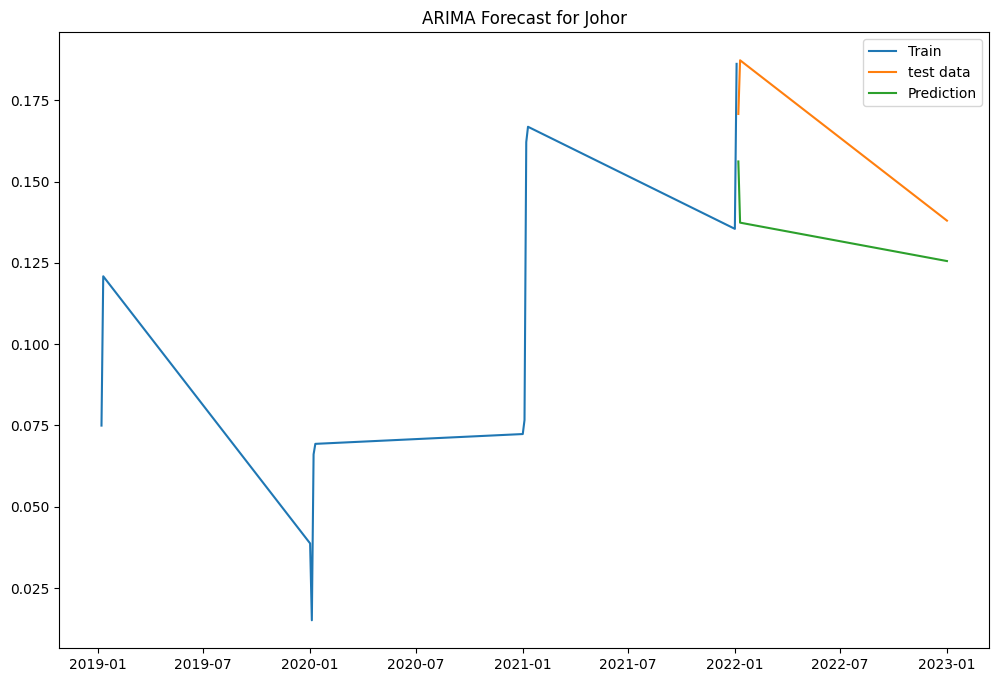

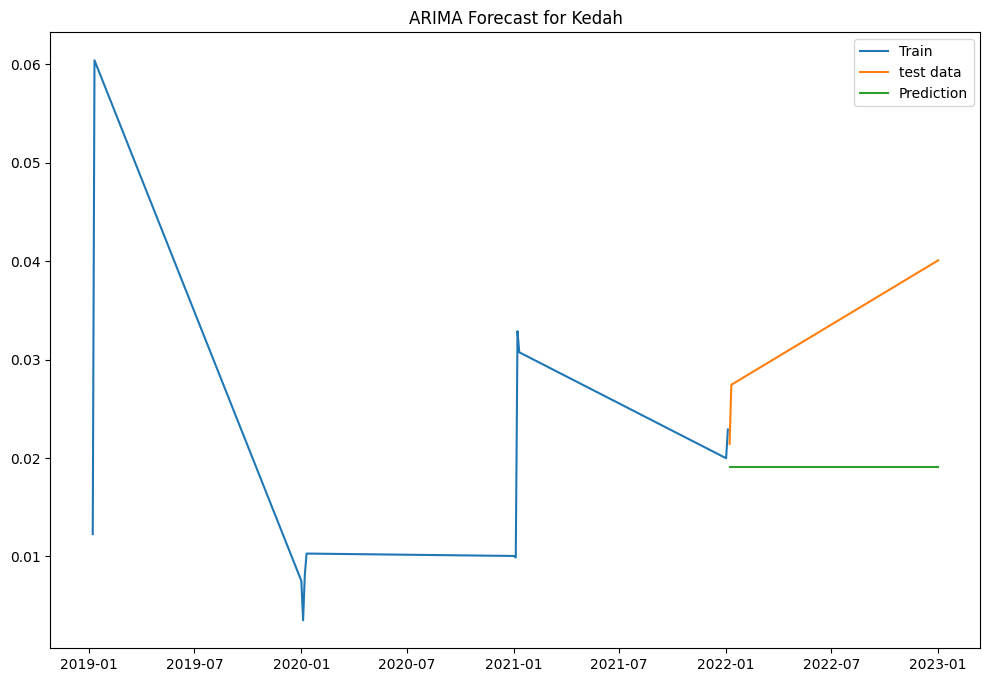

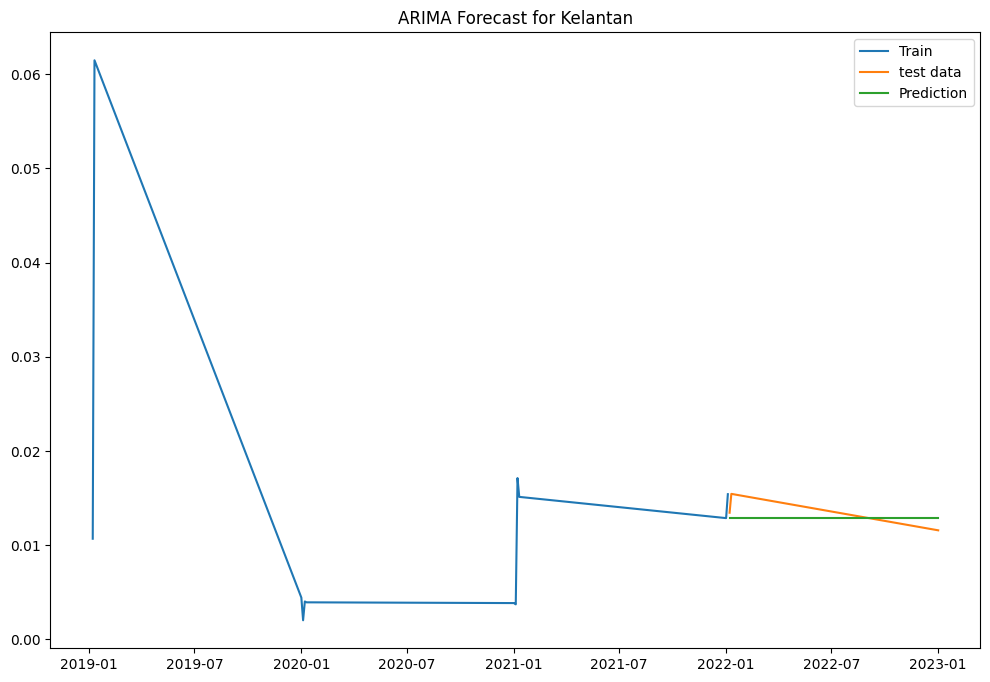

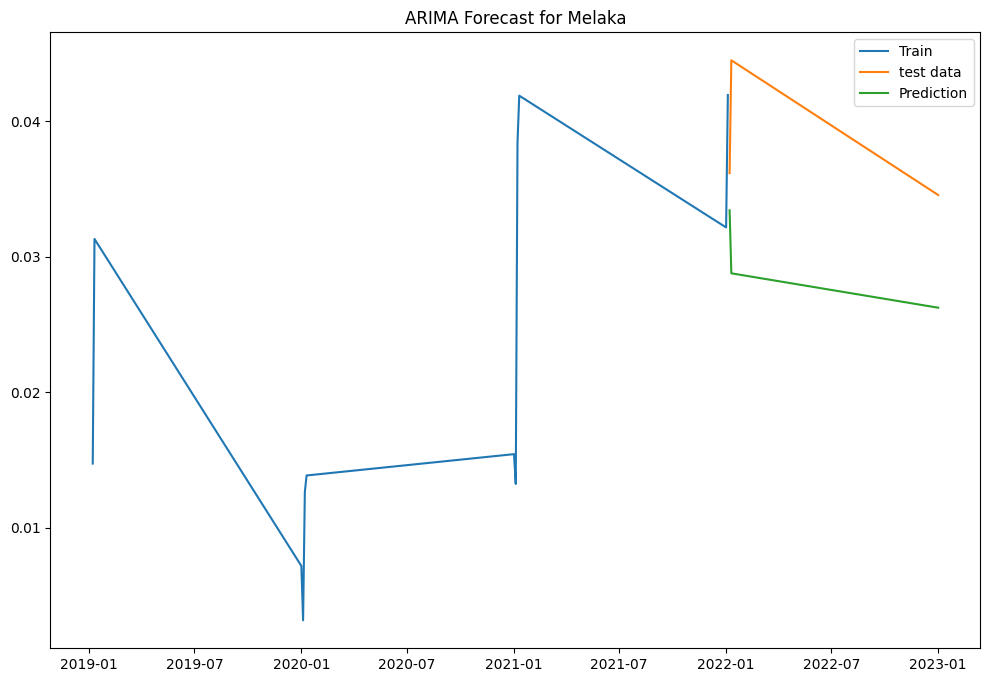

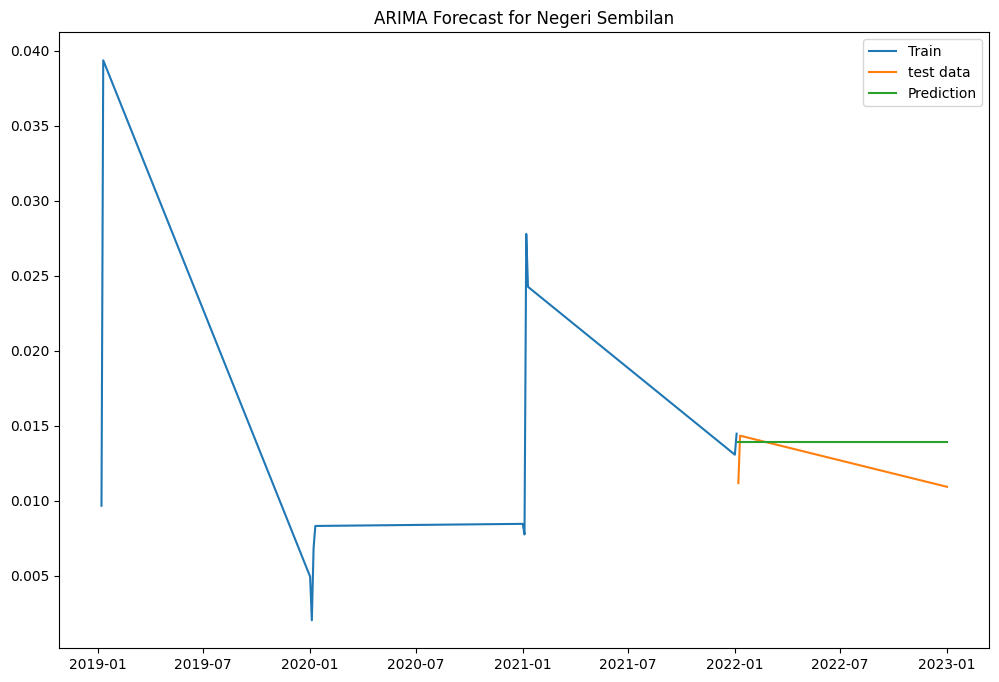

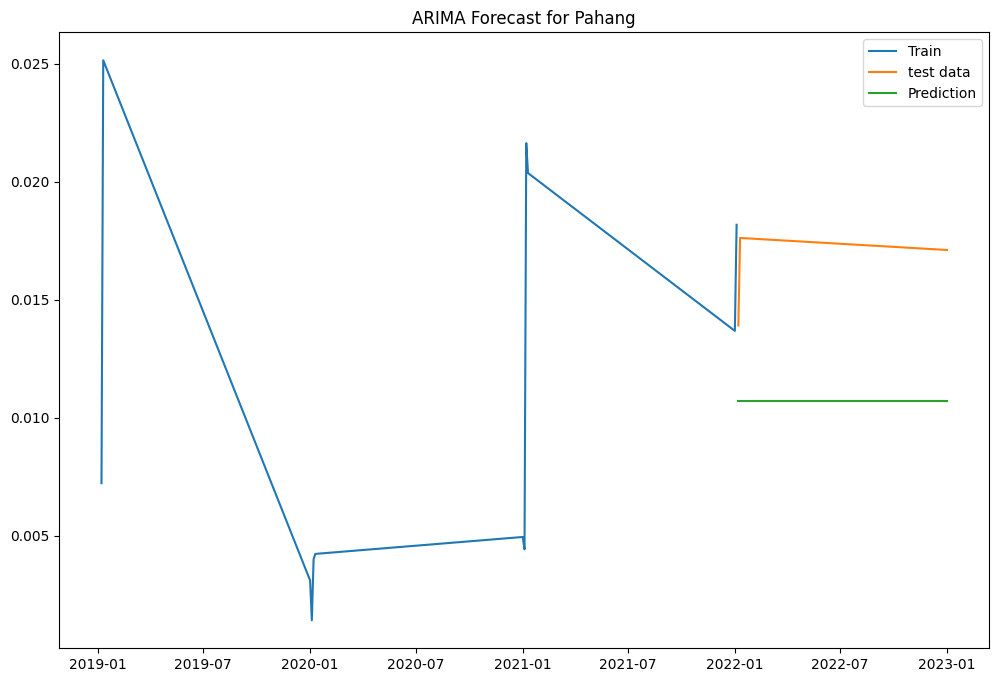

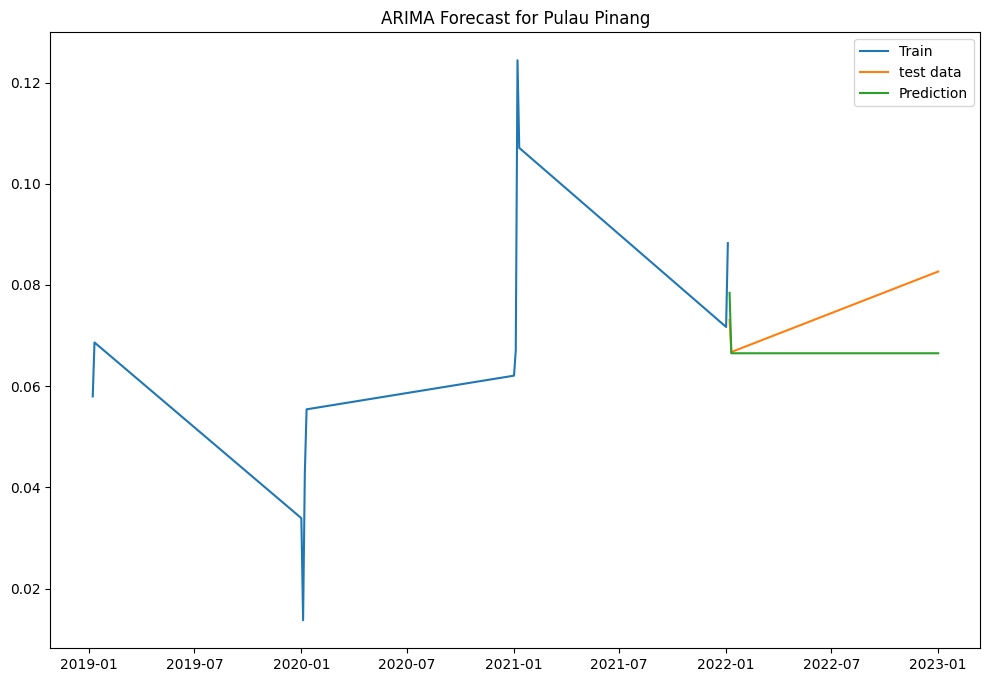

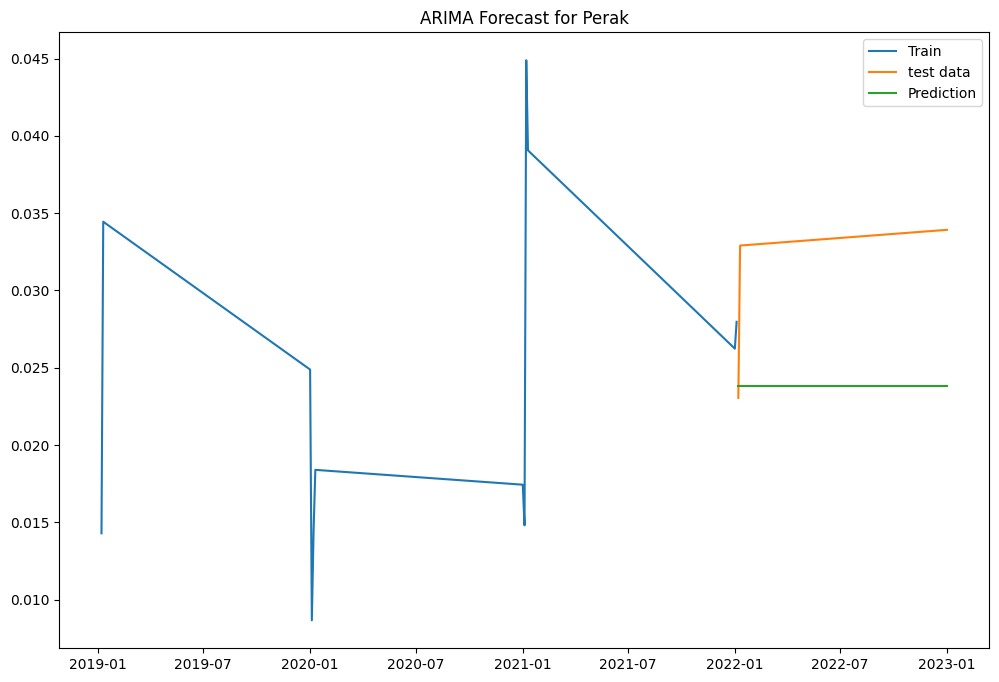

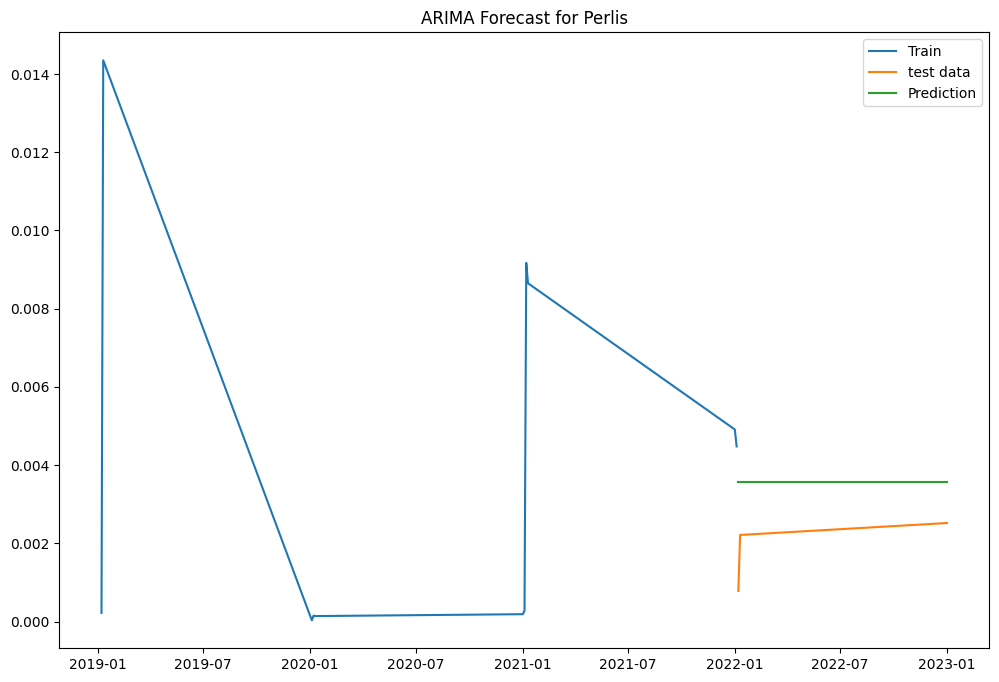

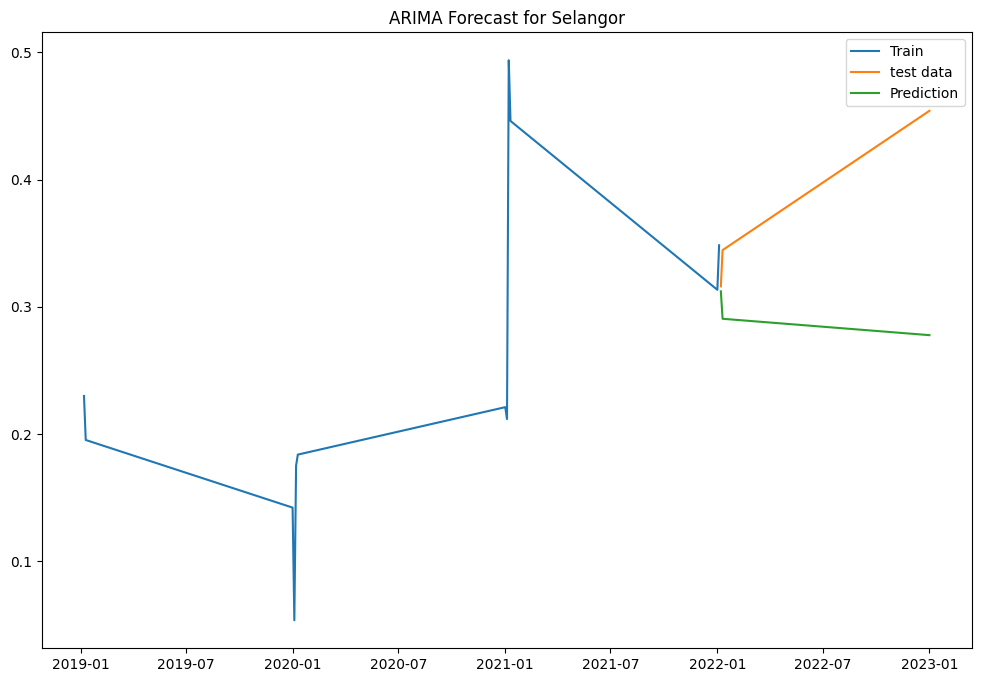

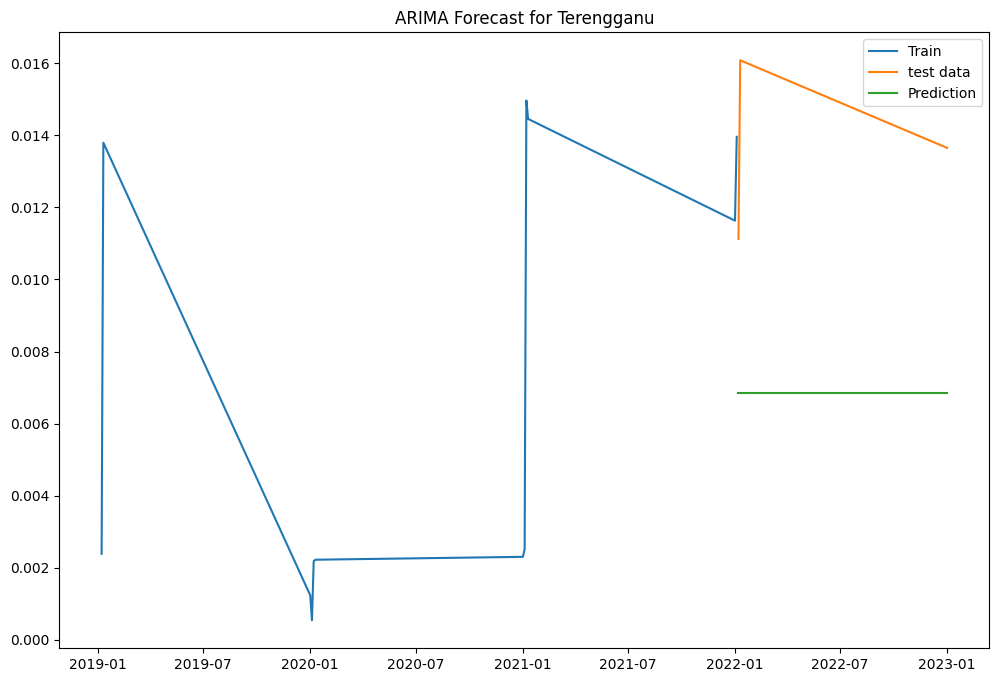

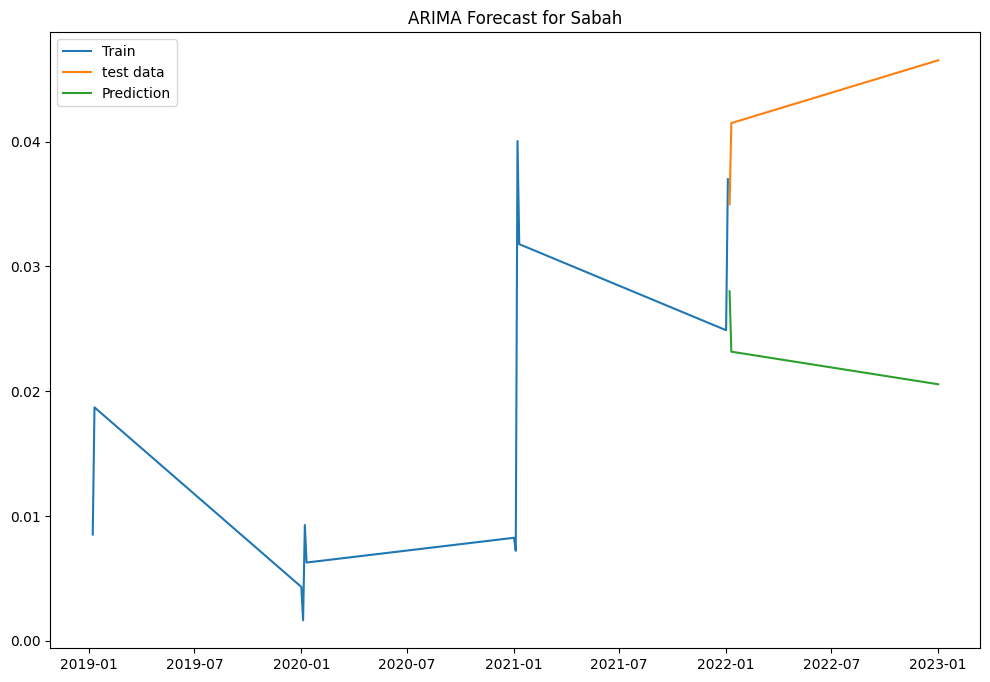

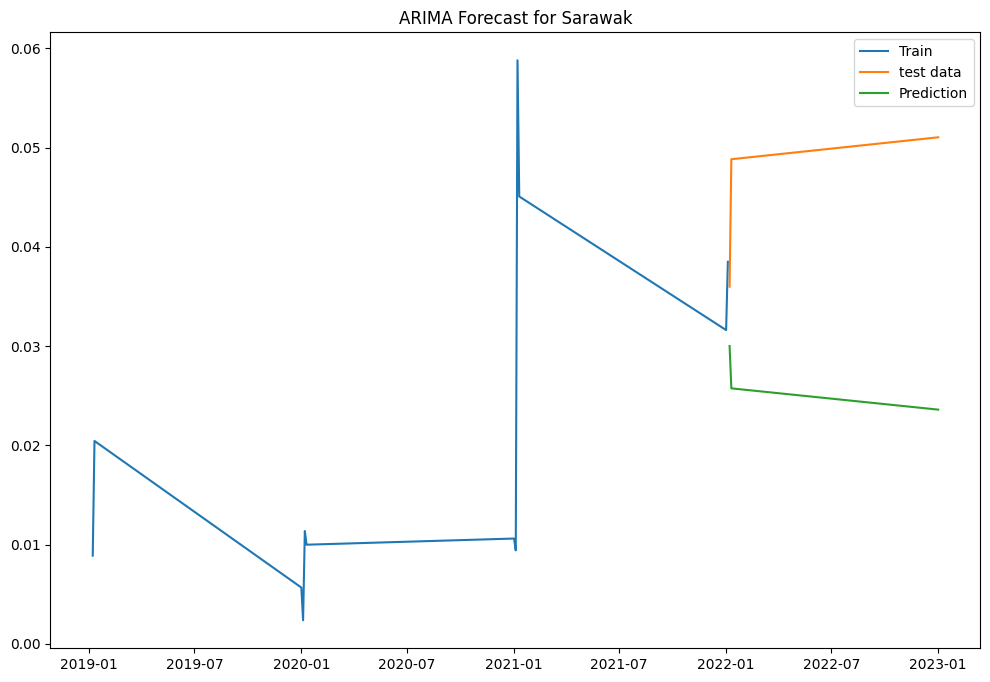

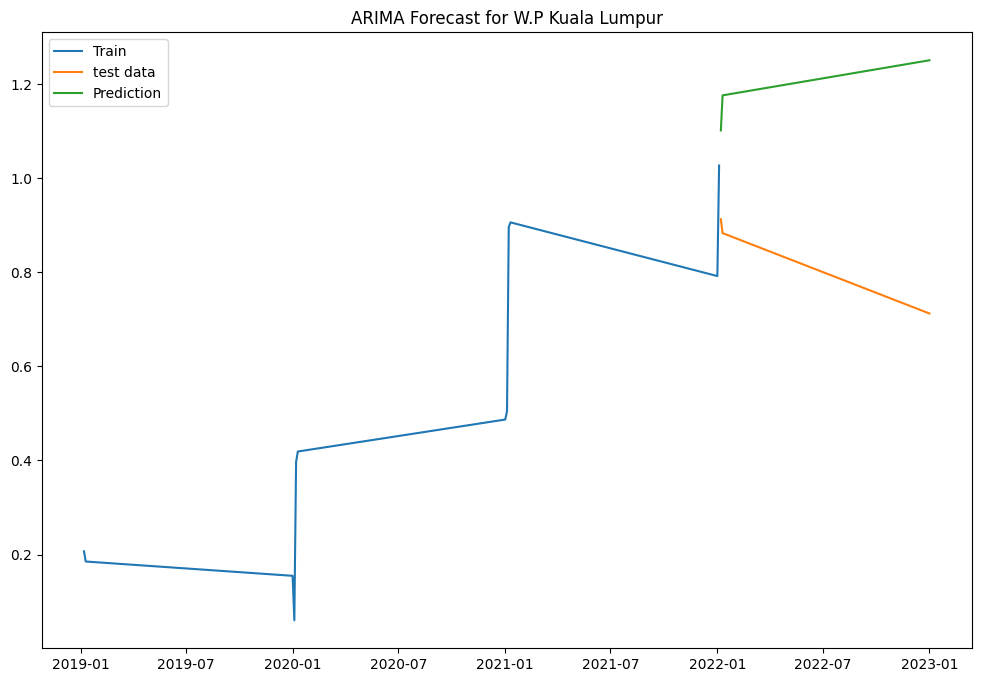

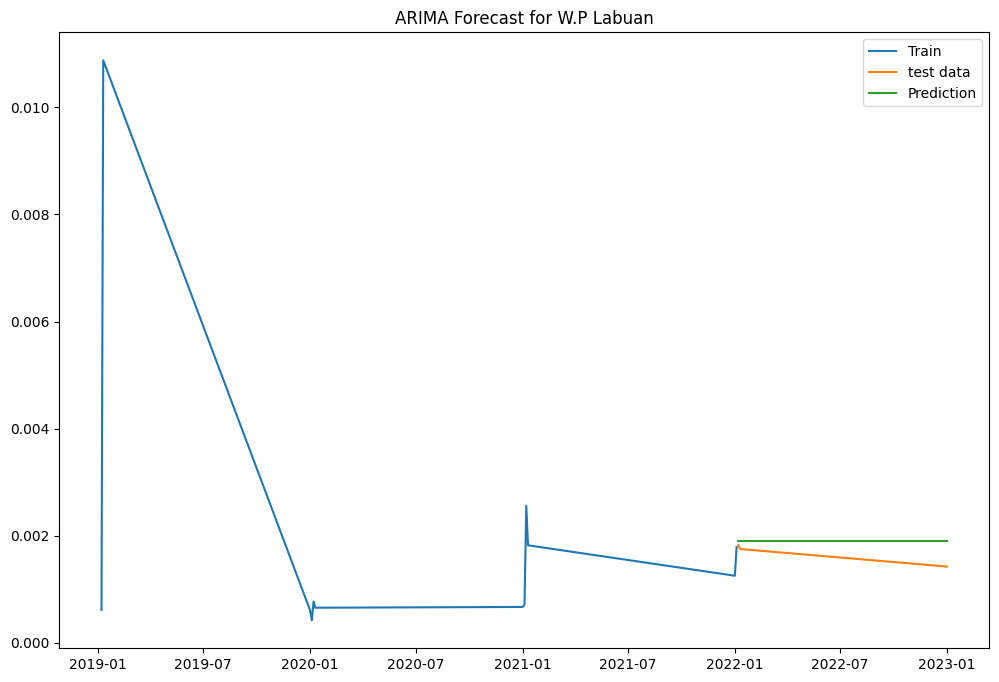

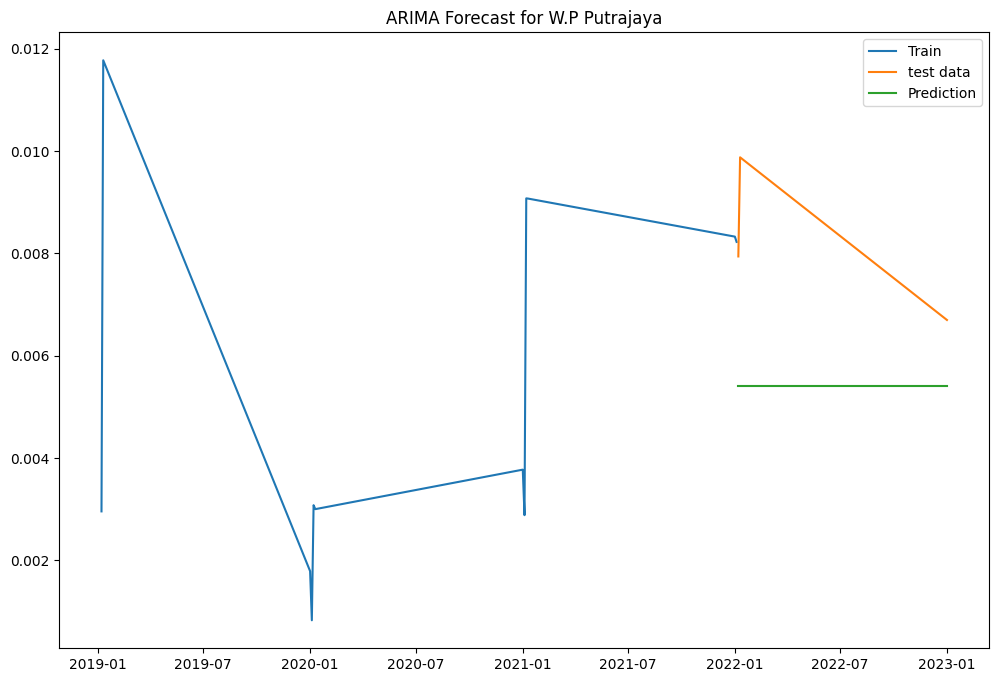

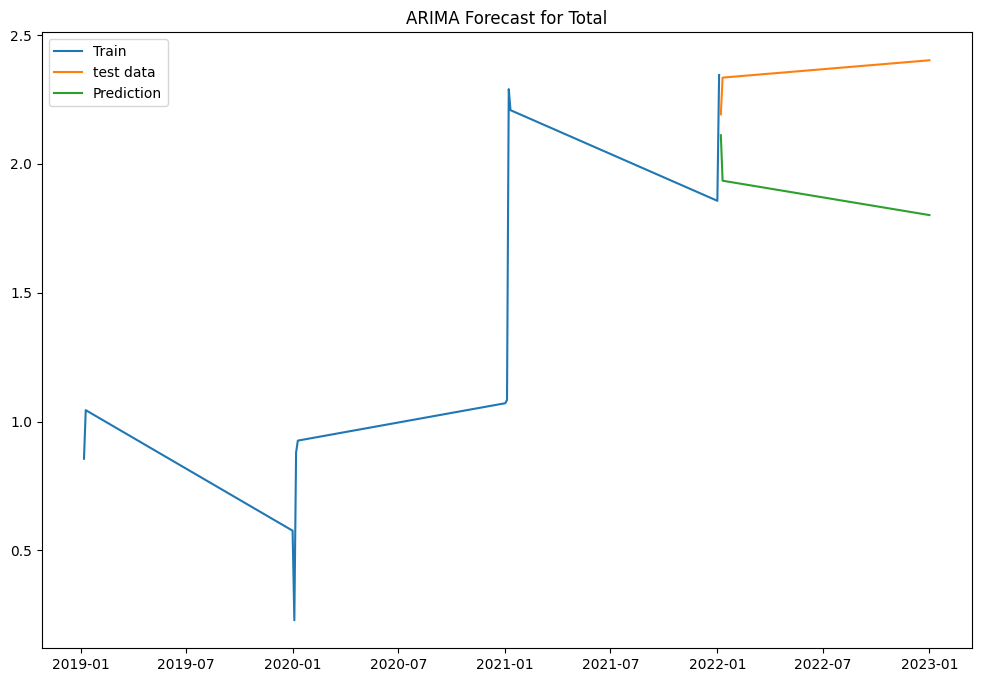

In [72]:
for i in range(df.shape[1]):
    column_name = df.columns[i]
    column_data = df.iloc[:, i]  # Access column data using iloc
    
    # plot the predictions for validation set
    # set the starting date at 2019-01-01
    plt.figure(figsize=(12,8))
    plt.plot(train.iloc[:,i], label='Train')
    plt.plot(test.iloc[:,i], label='test data')
    plt.plot(ARIMA_forecast.iloc[:,i], label='Prediction')
    plt.title(f'ARIMA Forecast for {column_name}')
    plt.legend(loc='best')

### ARIMA Accuracy Testing

In [67]:
# make a empty data frame to store the error
error_df_ARIMA = pd.DataFrame({'MSE': [], 'RMSE': [], 'MAE': []})

for i in range(df.shape[1]):
    mae = mean_absolute_error(test.iloc[:,i], ARIMA_forecast.iloc[:,i])
    mse = mean_squared_error(test.iloc[:,i], ARIMA_forecast.iloc[:,i])
    rmse = np.sqrt(mse)
    # Create a DataFrame from the current values
    new_row = pd.DataFrame({'MSE': [mse], 'RMSE': [rmse], 'MAE': [mae]})

    # Concatenate the new DataFrame with the existing error_df_ARIMA
    error_df_ARIMA = pd.concat([error_df_ARIMA, new_row], ignore_index=True)

error_df_ARIMA.index = test.columns


In [68]:
# compare all the error from error_df_ETS and error_df_ARIMA by row 
ETS['Model'] = 'ETS'
error_df_ARIMA['Model'] = 'ARIMA'
print(ETS)
print(error_df_ARIMA)

                 Trend Seasonal       MSE      RMSE       MAE Model
Johor              add      add  0.001539  0.039229  0.029139   ETS
Kedah              add      add  0.000133  0.011527  0.010608   ETS
Kelantan           add      add   0.00013  0.011385  0.010002   ETS
Melaka             add      add  0.000081  0.008996  0.007675   ETS
Negeri Sembilan    add      add  0.000133  0.011544  0.010533   ETS
Pahang             add      add  0.000023  0.004818  0.004353   ETS
Pulau Pinang       add      add  0.003227  0.056809  0.056506   ETS
Perak              add      add  0.000105  0.010236   0.00939   ETS
Perlis             add      add  0.000033  0.005733  0.005243   ETS
Selangor           add      add  0.020472   0.14308  0.141265   ETS
Terengganu         add      add  0.000007  0.002646  0.002272   ETS
Sabah              add      add  0.000003  0.001736  0.001481   ETS
Sarawak            add      add  0.000091  0.009565  0.007457   ETS
W.P Kuala Lumpur   add      add  0.164433  0.405

In [ ]:
# Johor - ARIMA
# Kedah - ETS
# Kelantan - ARIMA
# Melaka - ETS
# N9 - ETS
# Pahang - ETS
# Pulau Pinang - ARIMA
# Perak - ARIMA
# Perlis - ETS
# Selangor - ARIMA
# Terengganu - ETS
# Sabah - ETS
# Sarawak - ETS
# Kuala Lumpur - ARIMA
# Labuan - ARIMA
# Putrajaya - ETS
# Total - ARIMA